### Comparing the initial Etv2 binding events between MEF and EB

In [57]:
library(GenomicRanges)
library(ChIPpeakAnno)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(BSgenome.Mmusculus.UCSC.mm10)
library(org.Mm.eg.db)
library(clusterProfiler)
library(gplots)
library(dplyr)
library(EnrichedHeatmap)
library(circlize)

circlize version 0.4.8
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: http://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization 
  in R. Bioinformatics 2014.



In [56]:
BiocManager::install('circlize')

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)
Installing package(s) 'circlize'
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'ade4', 'digest', 'evaluate', 'IRkernel', 'jsonlite', 'Rcpp',
  'repr', 'Rsamtools'


In [63]:
maxgap_summit_overlap <- 200L
all_etv2_peaks_url <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds'

In [11]:
# Read the Etv2 ChIP-seq peaks in MEF (D1 post Etv2 induction) and D2.5 EB (3h post induction).
bed_files <- c(
  'MEF_Dox_d1_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_summits.bed',
  'EB_Dox_3h_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_3h_Etv2_summits.bed'
)
gr_list <- lapply(1:length(bed_files), function(i){
  x <-read.table(bed_files[i], header = FALSE, sep = '\t')
  gr <- GRanges(seqnames = x[, 1], range = IRanges(x[, 2], x[, 3]), score = x[, 5])
  names(gr) <- x[, 4]
  gr
})
names(gr_list) <- names(bed_files)

In [22]:
# Looking at the overlap of Etv2 peaks
ol <- findOverlapsOfPeaks(gr_list$MEF_Dox_d1_Etv2, gr_list$EB_Dox_3h_Etv2, maxgap = maxgap_summit_overlap)
names(ol$peaklist) <- c('EB', 'MEF', 'MEF&EB')

In [21]:
# Show the peaks in each category
sapply(ol$peaklist, length)

EB    MEF MEF&EB 
  6273 119260  11751

In [36]:
11751 / (6273 + 11751)

[1] 0.651964

In [25]:
# Check the ditribution of Etv2 peaks across the genome
anno_list <- lapply(ol$peaklist, function(p)
  annotatePeak(p, tssRegion = c(-5000, 1000), TxDb = TxDb.Mmusculus.UCSC.mm10.knownGene, annoDb = "org.Mm.eg.db")
)

>> preparing features information...		 2020-02-12 10:50:31 
>> identifying nearest features...		 2020-02-12 10:50:32 
>> calculating distance from peak to TSS...	 2020-02-12 10:50:33 
>> assigning genomic annotation...		 2020-02-12 10:50:33 
>> adding gene annotation...			 2020-02-12 10:50:51 


'select()' returned 1:many mapping between keys and columns


>> assigning chromosome lengths			 2020-02-12 10:50:51 
>> done...					 2020-02-12 10:50:51 
>> preparing features information...		 2020-02-12 10:50:51 
>> identifying nearest features...		 2020-02-12 10:50:51 
>> calculating distance from peak to TSS...	 2020-02-12 10:50:54 
>> assigning genomic annotation...		 2020-02-12 10:50:54 
>> adding gene annotation...			 2020-02-12 10:50:56 


'select()' returned 1:many mapping between keys and columns


>> assigning chromosome lengths			 2020-02-12 10:50:57 
>> done...					 2020-02-12 10:50:57 
>> preparing features information...		 2020-02-12 10:50:57 
>> identifying nearest features...		 2020-02-12 10:50:57 
>> calculating distance from peak to TSS...	 2020-02-12 10:50:58 
>> assigning genomic annotation...		 2020-02-12 10:50:58 
>> adding gene annotation...			 2020-02-12 10:51:00 


'select()' returned 1:many mapping between keys and columns


>> assigning chromosome lengths			 2020-02-12 10:51:00 
>> done...					 2020-02-12 10:51:00 


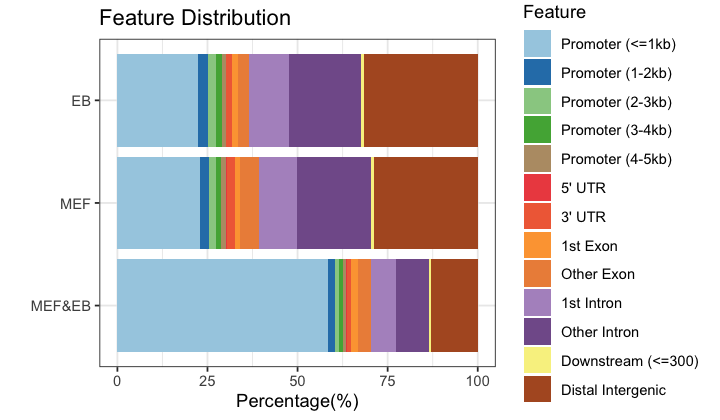

In [34]:
options(repr.plot.width=6, repr.plot.height=3.5)
plotAnnoBar(anno_list)

In [8]:
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_summits.bed'
peaks <- read.table(bed_file, sep = '\t', header = FALSE)
peaks <- GRanges(seqnames = peaks[, 1], range = IRanges(peaks[, 2], peaks[, 3]))
seqlevels(peaks) <- seqlevels(BSgenome.Mmusculus.UCSC.mm10)
seqlengths(peaks) <- seqlengths(BSgenome.Mmusculus.UCSC.mm10)
seqinfo(peaks) <- seqinfo(BSgenome.Mmusculus.UCSC.mm10)


In [13]:
predict_file <- 'https://s3.msi.umn.edu/gongx030/projects/seatac/models/peak=EB_Dox_3h_Etv2_bam=EB_NoDox_D25_latent_dim=10_window_size=640_bin_size=5_fragment_size_range=50+370_fragment_size_interval=5_min_num_reads=20_max_num_reads=500/predict.rds'
gr <- readRDS(gzcon(url(predict_file)))
gr[1:5]

GRanges object with 5 ranges and 9 metadata columns:
      seqnames          ranges strand |    MEF_MNase     group      counts
         <Rle>       <IRanges>  <Rle> |     <matrix> <integer> <dgCMatrix>
  [1]     chr1 3263570-3264209      * | 10:10:10:...         1   0:0:0:...
  [2]     chr1 4213816-4214455      * | 20:20:18:...         1   0:0:0:...
  [3]     chr1 4491717-4492356      * | 15:15:13:...         1   0:0:0:...
  [4]     chr1 4491995-4492634      * |    2:2:2:...         1   0:0:0:...
  [5]     chr1 4493025-4493664      * |    2:2:2:...         1   0:0:0:...
      num_reads window_id
      <numeric> <integer>
  [1]        64         1
  [2]       240         3
  [3]       171         5
  [4]       186         6
  [5]       329         7
                                                           latent
                                                         <matrix>
  [1]    1.03999447822571:-0.434088677167892:0.94003164768219:...
  [2]     -1.5942679643631:2.1102907657623

# peaks at nucleosome: 8843
# peaks at NFR: 5291


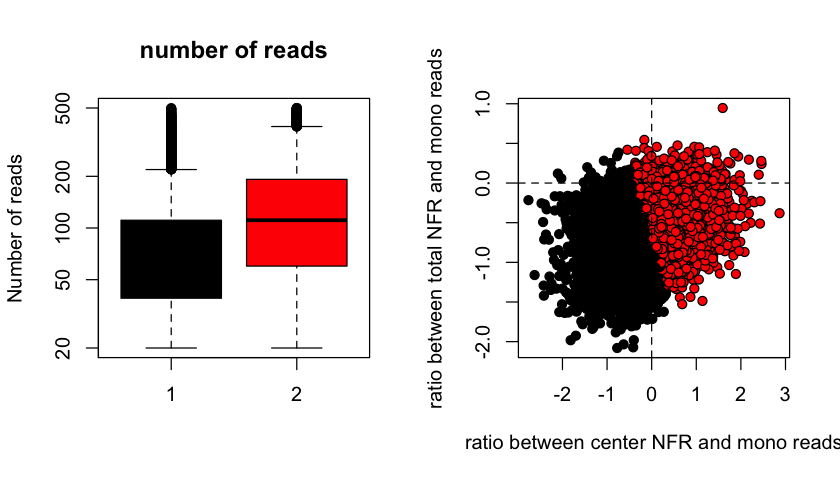

In [25]:
h <- log(rowSums(gr$nfr_reads[, (64 - 3):(64 + 3)]) + 1) - log(rowSums(gr$mono_nucleosome_reads[, (64 - 3):(64 + 3)]) + 1)
v <- log(rowSums(gr$nfr_reads) + 1) - log(rowSums(gr$mono_nucleosome_reads) + 1)
options(repr.plot.width=7, repr.plot.height=4)
par(mfrow = c(1, 2))
k <- 2
set.seed(1); gr$cluster <- kmeans(cbind(h, v), k)$cluster
boxplot(split(gr$num_reads, list(gr$cluster)), col = 1:k, log = 'y', main = 'number of reads', ylab = 'Number of reads')
plot(h, v, pch = 21, bg = gr$cluster, xlab = 'ratio between center NFR and mono reads', ylab = 'ratio between total NFR and mono reads')
abline(h = 0, v = 0, lty = 2)
cat(sprintf('# peaks at nucleosome: %s\n', sum(gr$cluster == 1)))
cat(sprintf('# peaks at NFR: %s\n', sum(gr$cluster == 2)))

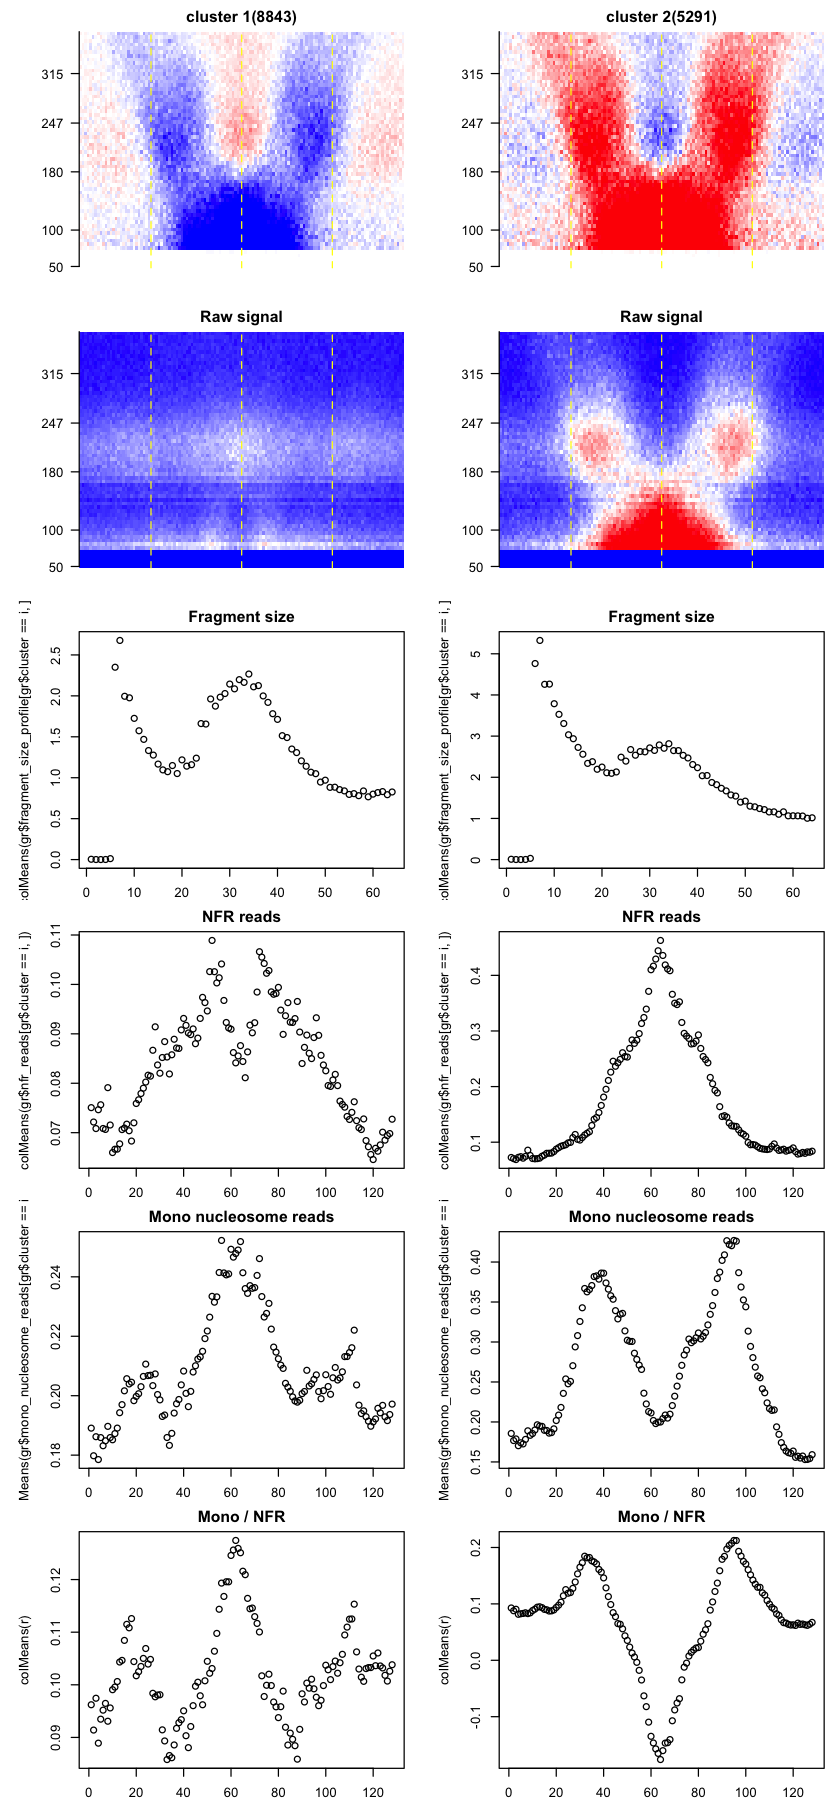

In [34]:
# Visualize the V-plot, fragment size profile, mono nucleosome reads and NFR reads pattern in each cluster
options(repr.plot.width=7, repr.plot.height=15)
par(mfcol = c(6, k), mar = c(2, 5, 2, 1))
bg <- colMeans(mcols(gr)$counts)
breaks_non_norm <- c(seq(0, max(bg) * 0.9, length.out = 100), 1)
breaks_norm <- c(-1, seq(-0.01, 0.01, length.out = 99), 1)
yy <- c(50, 100, 180, 247, 315, 473)
for (i in 1:k){
  x <- colMeans(mcols(gr)$counts[gr$cluster == i, ])
  x_norm <- matrix(x - bg, metadata(gr)$n_bins_per_window, metadata(gr)$n_intervals)
  image(x_norm, col = colorpanel(100, low = 'blue', mid = 'white', high = 'red'), breaks = breaks_norm, main = sprintf('cluster %d(%d)', i, sum(gr$cluster == i)), axes = FALSE)
  axis(2, at = (yy - metadata(gr)$fragment_size_range[1]) / (metadata(gr)$fragment_size_range[2] - metadata(gr)$fragment_size_range[1]), label = yy, las = 2)
  abline(v = c(0.5 - (1:4) * 180 /metadata(gr)$window_size , 0.5, (1:4) * 180/ metadata(gr)$window_size + 0.5), col = 'yellow', lty = 2)
  x_non_norm <- matrix(x, metadata(gr)$n_bins_per_window, metadata(gr)$n_intervals)
  image(x_non_norm, col = colorpanel(100, low = 'blue', mid = 'white', high = 'red'), breaks = breaks_non_norm, main = 'Raw signal', axes = FALSE)
  axis(2, at = (yy - metadata(gr)$fragment_size_range[1]) / (metadata(gr)$fragment_size_range[2] - metadata(gr)$fragment_size_range[1]), label = yy, las = 2)
  abline(v = c(0.5 - (1:4) * 180 /metadata(gr)$window_size , 0.5, (1:4) * 180/ metadata(gr)$window_size + 0.5), col = 'yellow', lty = 2)
  plot(colMeans(gr$fragment_size_profile[gr$cluster == i, ]), main = 'Fragment size')
  plot(colMeans(gr$nfr_reads[gr$cluster == i, ]), main = 'NFR reads')
  plot(colMeans(gr$mono_nucleosome_reads[gr$cluster == i, ]), main = 'Mono nucleosome reads')
  r <- log(gr$mono_nucleosome_reads[gr$cluster == i, ] + 1) - log(gr$nfr_reads[gr$cluster == i, ] + 1)
  plot(colMeans(r), main = 'Mono / NFR')
}

In [ ]:
# normaliz2matrix files for EnrichedHeatmap package
# EnrichedHeatmap::normalizeToMatrix is very slow so these matrices were generated at msi
n2m_files <- c(
  MNase = 'https://s3.msi.umn.edu/gongx030/normalizeToMatrix/peaks=EB_Dox_3h_Etv2_group=MNase_extend=1000_w=50_smooth=FALSE_target_ratio=0.200.rds',
  EB_NoDox_D25 = 'https://s3.msi.umn.edu/gongx030/normalizeToMatrix/peaks=EB_Dox_3h_Etv2_group=EB_NoDox_D25_extend=1000_w=50_smooth=FALSE_target_ratio=0.200.rds',
  EB_Dox_3h_Etv2 = 'https://s3.msi.umn.edu/gongx030/normalizeToMatrix/peaks=EB_Dox_3h_Etv2_group=EB_Dox_3h_Etv2_extend=1000_w=50_smooth=FALSE_target_ratio=0.200.rds',
  EB_Dox_12h_Etv2 = 'https://s3.msi.umn.edu/gongx030/normalizeToMatrix/peaks=EB_Dox_3h_Etv2_group=EB_Dox_12h_Etv2_extend=1000_w=50_smooth=FALSE_target_ratio=0.200.rds',
  EB_NoDox_D25_mono_vs_nfr = 'https://s3.msi.umn.edu/gongx030/normalizeToMatrix/peaks=EB_Dox_3h_Etv2_group=EB_NoDox_D25_mono_vs_nfr_extend=1000_w=50_smooth=FALSE_target_ratio=0.200.rds',
  EB_NoDox_3h_Brg1 = 'https://s3.msi.umn.edu/gongx030/normalizeToMatrix/peaks=EB_Dox_3h_Etv2_group=EB_NoDox_3h_Brg1_extend=1000_w=50_smooth=FALSE_target_ratio=0.200.rds',
  EB_NoDox_3h_H3K27ac = 'https://s3.msi.umn.edu/gongx030/normalizeToMatrix/peaks=EB_Dox_3h_Etv2_group=EB_NoDox_3h_H3K27ac_extend=1000_w=50_smooth=FALSE_target_ratio=0.200.rds'
)
mat <- lapply(n2m_files, function(f) readRDS(gzcon(url(f))))
names(mat) <- names(n2m_files)

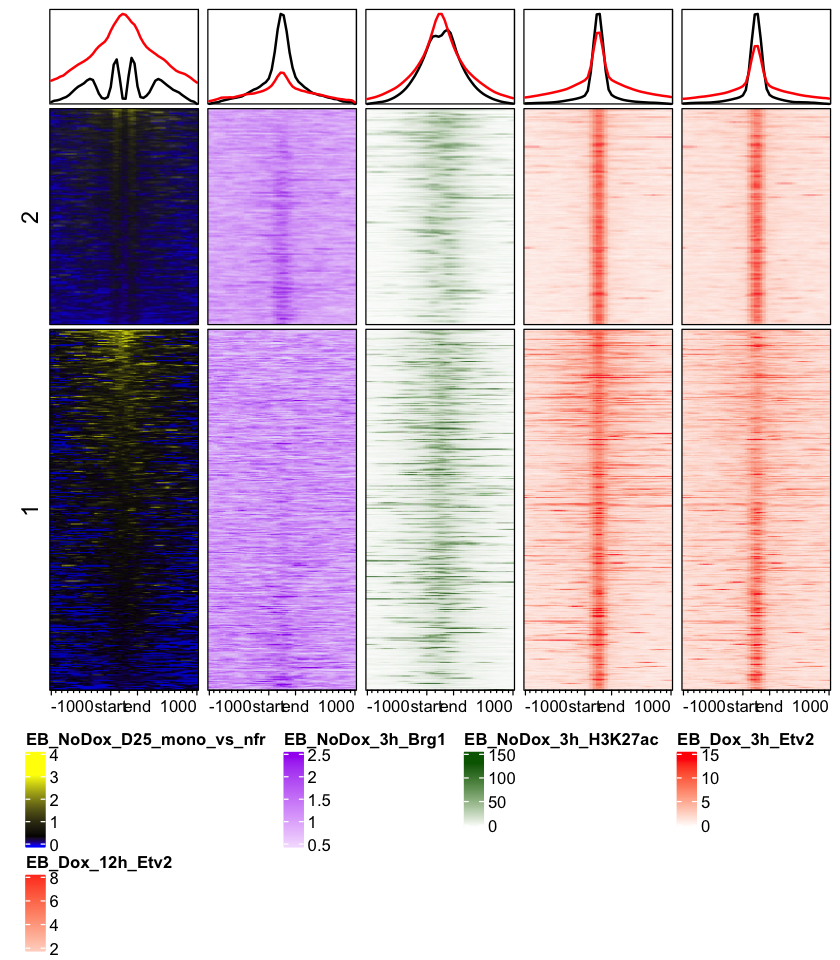

In [61]:
group_cols <- rep('blue', length(n2m_files))
names(group_cols) <- names(n2m_files)
group_cols['MNase'] <- 'green'
group_cols['EB_Dox_3h_Etv2'] <- 'red'
group_cols['EB_Dox_12h_Etv2'] <- 'red'
group_cols['EB_NoDox_3h_Brg1'] <- 'purple'
group_cols['EB_NoDox_3h_H3K27ac'] <- 'darkgreen'
col_fun <- lapply(1:length(mat), function(i) colorRamp2(quantile(mat[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- names(n2m_files)
col_fun[['EB_NoDox_D25_mono_vs_nfr']] <- colorRamp2(quantile(mat[['EB_NoDox_D25_mono_vs_nfr']], c(0.005, 0.5, 0.995)), c('blue', 'black', 'yellow'))

i <- 1:length(gr)
sp <- factor(gr$cluster, c(2, 1))
ta <- HeatmapAnnotation(
  enriched = anno_enriched(
    gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
    axis_param = list(facing = 'inside', at = -1000)
  )
)
h <- EnrichedHeatmap(
  mat[['EB_NoDox_D25_mono_vs_nfr']][i, ], 
  col = col_fun[['EB_NoDox_D25_mono_vs_nfr']], 
  split = sp[i], 
  name = 'EB_NoDox_D25_mono_vs_nfr', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c('EB_NoDox_3h_Brg1', 'EB_NoDox_3h_H3K27ac', 'EB_Dox_3h_Etv2', 'EB_Dox_12h_Etv2')
for (s in ss[ss %in% names(n2m_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width=7, repr.plot.height=8)
draw(h, heatmap_legend_side = 'bottom')

In [64]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.2

Matrix products: default
BLAS/LAPACK: /Users/gongx030/anaconda3/envs/r/lib/libopenblasp-r0.3.7.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] circlize_0.4.8                           
 [2] EnrichedHeatmap_1.16.0                   
 [3] ComplexHeatmap_2.2.0                     
 [4] dplyr_0.8.4                              
 [5] s3msi_0.001                              
 [6] gplots_3.0.1.2                           
 [7] BSgenome.Mmusculus.UCSC.mm10_1.4.0       
 [8] BSgenome_1.54.0                          
 [9] rtracklayer_1.46.0                       
[10] clusterProfiler_3.14.3                   
[11] org.Mm.eg.db_3.10.0                      
[12] TxDb.Mmusculus.UCSC.mm10.kno